## Model Final

In [1]:
import os
import csv
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Cropping2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, SpatialDropout2D , ELU
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.utils import np_utils
from PIL import Image
import pickle

%matplotlib inline

Using TensorFlow backend.


-------

### Generator

In [2]:
def generator(samples, batch_size):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                name = batch_sample[1]
                
                if name[0] ==' ':
                    name = name[1:]
                center_image = mpimg.imread(name)
                center_angle = float(batch_sample[2])
                images.append(center_image)
                angles.append(center_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)


--------

### Model 

In [3]:
def get_model(verbose):

    # Model adapted from Comma.ai model

    model = Sequential()

    # Crop 70 pixels from the top of the image and 25 from the bottom
    model.add(Cropping2D(input_shape=(160, 320, 3),
                         cropping=((70, 25), (0, 0)),
                         data_format="channels_last"))
    
    # Normalise the data
    model.add(Lambda(lambda x: (x/255.0) - 0.5))

    # Conv layer 1
    model.add(Convolution2D(16, (8, 8), padding="same", strides=(4, 4)))
    model.add(ELU())

    
    # Conv layer 2
    model.add(Convolution2D(32, (5, 5), padding="same", strides=(2, 2)))
    model.add(ELU())

    # Conv layer 3
    model.add(Convolution2D(64, (5, 5), padding="same", strides=(2, 2)))
              

    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())

    # Fully connected layer 1
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())

    # Fully connected layer 2
    model.add(Dense(50))
    model.add(ELU())

    model.add(Dense(1))

    adam = Adam(lr=0.0001)

    model.compile(optimizer=adam, loss="mse", metrics=['accuracy'])
    if verbose:
        print("Model summary:\n", model.summary())
    return model

###  Train model

In [4]:
def train_model(batch_size, nb_epoch, verbose=False):
    
    samples = []
    with open('all_log.csv') as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                samples.append(line)
            
    l1 = len(samples)
    print("Normal-data Samples1: ", len(samples))    
            
    # Remove header
    samples = samples[1:]
        
        
        
        
    # Split samples into training and validation sets to reduce overfitting
    train_samples, validation_samples = train_test_split(samples, test_size=0.1)

    
    # compile and train the model using the generator function
    train_generator = generator(train_samples, batch_size)
    validation_generator = generator(validation_samples, batch_size)
    
    
    # call the model
    model = get_model(verbose)

    # Train model using generator
    history_object = model.fit_generator(train_generator, 
                     steps_per_epoch = len(train_samples), 
                     validation_data = validation_generator,
                     validation_steps = len(validation_samples),
                     epochs = nb_epoch)
            

    # print the keys contained in the history object
    print(history_object.history.keys())


    # Save model
    model.save("model.h5")
    #print("Saved model to disk")
    return history_object
    

--------

### Plotter

In [5]:
def plotter(history_object):
    # plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

-------

### Run

Training comma.ai model
Normal-data Samples1:  24109
Epoch 1/20
21697/21697 [==============================] - 4745s - loss: 0.0131 - acc: 0.1804 - val_loss: 0.0164 - val_acc: 0.1855
Epoch 2/20
21697/21697 [==============================] - 2321s - loss: 0.0059 - acc: 0.1804 - val_loss: 0.0164 - val_acc: 0.1855
Epoch 3/20
21697/21697 [==============================] - 2110s - loss: 0.0044 - acc: 0.1804 - val_loss: 0.0163 - val_acc: 0.1855
Epoch 4/20
21697/21697 [==============================] - 2110s - loss: 0.0037 - acc: 0.1804 - val_loss: 0.0157 - val_acc: 0.1855
Epoch 5/20
21697/21697 [==============================] - 2106s - loss: 0.0032 - acc: 0.1804 - val_loss: 0.0155 - val_acc: 0.1855
Epoch 6/20
21697/21697 [==============================] - 2109s - loss: 0.0029 - acc: 0.1804 - val_loss: 0.0147 - val_acc: 0.1856
Epoch 7/20
21697/21697 [==============================] - 2112s - loss: 0.0027 - acc: 0.1804 - val_loss: 0.0147 - val_acc: 0.1855
Epoch 8/20
21697/21697 [=============

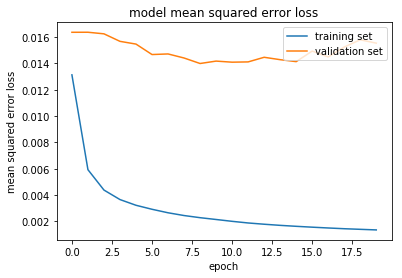

In [7]:
if __name__ == '__main__':
    
    # set the parameters
    batch_size = 8
    nb_epoch = 20
    verbose = False
    print('Training comma.ai model')
    history_object = train_model(batch_size, nb_epoch, verbose)
    print('DONE: Training comma.ai model')
    
    # plot the error
    plotter(history_object)

-----------